In [27]:
%cd /raid6/home/yokoyama/har-for-or/
import os
import pickle
from glob import glob

import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F
from tqdm import tqdm
from webdataset import WebLoader

from src.data import load_dataset_iterable
from src.model.individual.csqvae import CSQVAE
from src.utils import video, yaml_handler, vis

/raid6/home/yokoyama/har-for-or


In [ ]:
model_type = "csqvae"
dataset_num = 3

if dataset_num == 3:
    video_num = 6
    # v = 3
elif dataset_num == 4:
    video_num = 9
    # v = 4
elif dataset_num == 5:
    video_num = 7
    # v = 5

v = 0
# v = 6
# v = 7

data_root = f"../datasets/dataset{dataset_num:02d}/train/{video_num:02d}"
# data_dirs = sorted(glob(os.path.join(data_root, "*/")))
data_dirs = [data_root]

checkpoint_dir = f"models/individual/{model_type}/version_{v}"

# load config
config_path = f"{checkpoint_dir}/individual-{model_type}.yaml"
config = yaml_handler.load(config_path)

# load classes
path = f"../datasets/dataset{dataset_num:02d}/annotation/classes.txt"
classes = np.loadtxt(path, str, usecols=0, delimiter=",")
classes = [c.title() for c in classes]

In [3]:
gpu_id = 1
device = f"cuda:{gpu_id}"

# load dataset
dataset, n_samples = load_dataset_iterable(data_dirs, "individual", config, False)
dataset = dataset.batched(1)
dataloader = WebLoader(dataset, num_workers=1)

# load model
model = CSQVAE(config)
model.configure_model()
model = model.to(device)

checkpoint_path = sorted(glob(f"{checkpoint_dir}/*.ckpt"))[-1]
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

In [ ]:
seq_len = config.seq_len
stride = config.stride

video_path = f"{data_dirs[0]}.mp4"
cap = video.Capture(video_path)
n_start_frame = 0
frame_size = cap.size
frame = cap.read()[1]
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
del cap

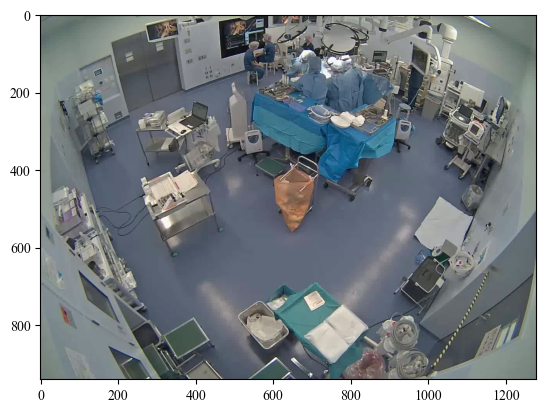

In [24]:
plt.imshow(frame)
plt.show()

In [29]:
data_dirs = glob(f"../datasets/dataset{dataset_num:02d}/train/*/") + glob(
    f"../datasets/dataset{dataset_num:02d}/test/*/"
)
data_dirs = sorted(data_dirs, key=lambda x: int(os.path.basename(os.path.dirname(x))))

# load annotation
path = glob(f"../datasets/dataset{dataset_num:02d}/annotation/*test*.txt")[0]
test_video_num = int(os.path.basename(path).split(".")[0].split("_")[2])

results = {}
for data_dir in tqdm(data_dirs):
    video_num = os.path.basename(os.path.dirname(data_dir))
    if int(video_num) != test_video_num:
        continue

    # load preds
    paths = glob(os.path.join(data_dir, f"pred_{model_type}", "*"))
    for path in paths:
        with open(path, "rb") as f:
            result = pickle.load(f)
            results[result["key"]] = result

100%|██████████| 19/19 [00:00<00:00, 21.98it/s]


In [30]:
n_frame = 49500
_id = 657
target_key = f"{test_video_num:02d}_{n_frame}_{_id}"
result = results[target_key]

# Sampling

In [11]:
def sampling(model: SQVAE, c: int, steps=90, book_idxs=None):
    if book_idxs is None:
        book_idxs = np.random.choice(model.quantizer.book_size, model.encoder.n_pts)
    book = model.quantizer.books[c]
    zq = book[book_idxs]

    kps = torch.empty((1, 0, 13, 2)).to(model.device)
    bbox = torch.empty((1, 0, 2, 2)).to(model.device)
    for t in tqdm(range(steps)):
        kps, bbox = model.decoder.sample_next_step(kps, bbox, zq)
    kps = kps.detach().cpu().numpy()[0]
    bbox = bbox.detach().cpu().numpy()[0]

    return kps, bbox


In [38]:
kps, bbox = sampling(model, result["label"], config.seq_len, result["book_idx"])

  0%|          | 0/90 [00:00<?, ?it/s]

100%|██████████| 90/90 [00:10<00:00,  8.79it/s]


In [ ]:
from src.data.transform.base import NormalizeBbox, NormalizeKeypoints
bbox = NormalizeBbox.reverse(bbox, frame_size)
for t in range(90):
    kps[t] = NormalizeKeypoints.reverse(kps[t], bbox[t])

In [40]:
kps.max(), kps.min()

(1153.9729, 348.42432)

In [41]:
bbox.max(), bbox.min()

(1179.8535919189453, 345.77508330345154)

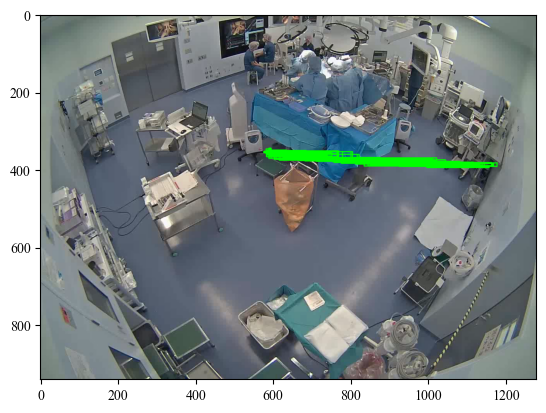

In [42]:
frame_bbox = frame.copy()
for b in bbox:
    frame_bbox = vis.draw_bbox(frame_bbox, b, color=(0, 255, 0))
plt.imshow(frame_bbox)
plt.show()

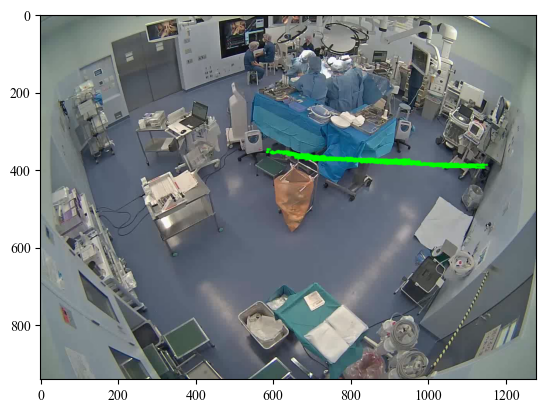

In [43]:

frame_kps = frame.copy()
for k in kps:
    frame_kps = vis.draw_skeleton(frame_kps, k, color=(0, 255, 0))
plt.imshow(frame_kps)
plt.show()